In [80]:
import zipfile
import os

# Path to the zip file
zip_path = "/content/drive/MyDrive/Dataset_Final_Exam_CV.zip"

# Destination directory
extract_to = "/content/Dataset_Final_Exam_CV"

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed.")


Extraction completed.


# Muhammad Maaz Hamid
# 2022655

# 1. Setup and Imports
First, let's import necessary libraries.

In [81]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import glob
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.v2 as T
from torchvision.models.segmentation.fcn import FCN, FCN_ResNet50_Weights # For FCN
from torchvision.models import vgg16, VGG16_Weights # For VGG16 backbone in custom FCN

# For metrics (excluding torchmetrics.Dice)
from torchmetrics import JaccardIndex, Accuracy

# For progress bars
from tqdm.auto import tqdm

# Set device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")



Using device: cuda


In [82]:
# For reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# To prevent CUDA launch blocking error in some environments (like Kaggle)
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.backends.cudnn.enabled = False # As per Kaggle notebook

## 2. Configuration and Constants

This block defines global parameters and dataset-specific information that will be used throughout the notebook.

*   **Dataset Paths:**
    *   `BASE_DATA_PATH`: Specifies the root directory of the dataset (`Dataset_Final_Exam_CV/cityscapes_data`).
    *   `TRAIN_DIR`, `VAL_DIR`: Define paths to the training and validation image subfolders.
*   **Image and Training Parameters:**
    *   `IMG_HEIGHT`, `IMG_WIDTH`: Set the target height and width for resizing images and masks.
    *   `BATCH_SIZE`: Determines the number of samples processed per iteration during training.
    *   `NUM_EPOCHS`: Specifies the total number of training epochs.
    *   `LEARNING_RATE`: Sets the initial learning rate for the optimizer.
*   **Class Information:**
    *   `CLASS_INFO`: A dictionary defining each semantic class, its corresponding RGB color in the annotation masks, its assigned class ID, and a human-readable name.
    *   `NUM_CLASSES`: Calculated as the total number of defined classes.
    *   `CLASS_NAMES`: A list of class names, ordered by their IDs.
    *   `ID_TO_COLOR`: A mapping from class ID to RGB color, used for visualizing predicted masks.
    *   `COLOR_TO_ID`: A mapping from RGB color to class ID, used for encoding ground truth masks.
    *   `IGNORE_INDEX`: Specifies the class ID (e.g., for "unlabeled") to be ignored during loss calculation and metric evaluation.
*   The block prints the number of classes, class names, and the ignore index for verification.


In [83]:
# Dataset paths (Update these if your dataset is elsewhere)
BASE_DATA_PATH = "/content/Dataset_Final_Exam_CV/cityscapes_data" # User specified
TRAIN_DIR = os.path.join(BASE_DATA_PATH, "train")
VAL_DIR = os.path.join(BASE_DATA_PATH, "val")

# Image and training parameters
IMG_HEIGHT = 256  # Or 128 for faster training
IMG_WIDTH = 512   # Or 256 for faster training
BATCH_SIZE = 8    # Adjust based on GPU memory
NUM_EPOCHS = 3   # Start with a small number for demonstration
LEARNING_RATE = 1e-4

In [84]:

# Define classes and their corresponding colors in the masks
# This is a simplified Cityscapes-like palette.
CLASS_INFO = {
    "unlabeled": {"color": (0, 0, 0), "id": 0, "name": "Unlabeled"},
    "road": {"color": (128, 64, 128), "id": 1, "name": "Road"},
    "sidewalk": {"color": (244, 35, 232), "id": 2, "name": "Sidewalk"},
    "building": {"color": (70, 70, 70), "id": 3, "name": "Building"},
    "car": {"color": (0, 0, 142), "id": 4, "name": "Car"},
    "pedestrian": {"color": (220, 20, 60), "id": 5, "name": "Pedestrian"},
    "pole": {"color": (153, 153, 153), "id": 6, "name": "Pole"},
    "traffic light": {"color": (250, 170, 30), "id": 7, "name": "Traffic Light"},
    "vegetation": {"color": (107, 142, 35), "id": 8, "name": "Vegetation"},
    # Add more if specified or found in masks, e.g., "sky"
}

NUM_CLASSES = len(CLASS_INFO)
CLASS_NAMES = [info["name"] for info in CLASS_INFO.values()]
ID_TO_COLOR = {info["id"]: info["color"] for info in CLASS_INFO.values()}
COLOR_TO_ID = {info["color"]: info["id"] for info in CLASS_INFO.values()}

IGNORE_INDEX = CLASS_INFO["unlabeled"]["id"]

print(f"Number of classes: {NUM_CLASSES}")
print(f"Class names (by ID order): {CLASS_NAMES}")
print(f"Ignore Index: {IGNORE_INDEX}")

Number of classes: 9
Class names (by ID order): ['Unlabeled', 'Road', 'Sidewalk', 'Building', 'Car', 'Pedestrian', 'Pole', 'Traffic Light', 'Vegetation']
Ignore Index: 0


## a) Data Acquisition and Preparation (03 marks)

This section focuses on loading the dataset, preprocessing images and masks, and preparing them for the model.

### Custom Dataset Class

This code defines the `CityscapesDataset` class, which inherits from PyTorch's `Dataset`. It's tailored to handle the specific combined image format (original image on the left, annotated mask on the right).

*   **`__init__(self, ...)`:**
    *   Initializes the dataset with the directory containing images, target image dimensions, class information, and optional transformation functions for images and masks.
    *   Uses `glob.glob(os.path.join(image_dir, "*.[jJ][pP][gG]"))` to find all JPEG image files (case-insensitive) in the specified directory. This was updated to handle `.jpg` files as per user feedback.
    *   Creates a `color_to_id` mapping from the `class_info` dictionary for mask encoding.
*   **`__len__(self)`:**
    *   Returns the total number of images in the dataset.
*   **`_split_image_mask(self, combined_img_pil)`:**
    *   A helper method that takes a combined PIL image as input.
    *   It splits the image horizontally: the left half is considered the original image, and the right half is the annotation mask.
    *   Returns the separated original image and mask as PIL images.
*   **`_encode_mask(self, mask_pil)`:**
    *   Takes an RGB PIL annotation mask as input.
    *   Converts the RGB mask to a single-channel mask where each pixel's value represents its class ID.
    *   Initializes a NumPy array (`encoded_mask_np`) with the `IGNORE_INDEX` and `dtype=np.uint8` (corrected for PIL compatibility).
    *   Iterates through the `color_to_id` map, finds pixels matching each class color, and assigns the corresponding class ID to `encoded_mask_np`.
    *   Returns the encoded mask as a PIL image (mode 'L').
*   **`__getitem__(self, idx)`:**
    *   This is the core method for fetching a single data sample.
    *   Loads the combined image from the path at the given `idx`.
    *   Calls `_split_image_mask` to separate the original image and the annotation mask.
    *   Resizes both the image (using `Image.BILINEAR` interpolation) and the mask (using `Image.NEAREST` interpolation to preserve class boundaries) to the specified `IMG_WIDTH` and `IMG_HEIGHT`.
    *   Calls `_encode_mask` to convert the resized RGB mask to an encoded ID mask (PIL image).
    *   Applies the provided `transform` (e.g., normalization) to the image tensor and `mask_transform` (e.g., conversion to LongTensor) to the mask tensor.
    *   If no specific transforms are provided, it defaults to converting PIL images to PyTorch tensors. The mask tensor is squeezed to remove the channel dimension, resulting in a (H,W) shape.
    *   Returns the processed image tensor and the encoded mask tensor.
    *   Includes error handling for image loading, returning dummy tensors if an image cannot be processed.


In [85]:
class CityscapesDataset(Dataset):
    def __init__(self, image_dir, img_height, img_width, class_info, transform=None, mask_transform=None):
        # Corrected glob pattern for .jpg images (case-insensitive)
        self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.[jJ][pP][gG]")))
        # If you are absolutely sure they are all lowercase .jpg:
        # self.image_paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")))

        if not self.image_paths:
            print(f"Warning: No images found in {image_dir}. Check the path and file extensions.")
        self.img_height = img_height
        self.img_width = img_width
        self.color_to_id = {info["color"]: info["id"] for name, info in class_info.items()}
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_paths)

    def _split_image_mask(self, combined_img_pil):
        w, h = combined_img_pil.size
        img = combined_img_pil.crop((0, 0, w // 2, h))
        mask = combined_img_pil.crop((w // 2, 0, w, h))
        return img, mask

    def _encode_mask(self, mask_pil):
        mask_np = np.array(mask_pil.convert("RGB"))
        # Corrected dtype to np.uint8 for PIL compatibility
        encoded_mask_np = np.full((mask_np.shape[0], mask_np.shape[1]), IGNORE_INDEX, dtype=np.uint8)

        for color_tuple, class_id in self.color_to_id.items():
            matches = np.all(mask_np == np.array(color_tuple), axis=-1)
            encoded_mask_np[matches] = class_id

        # PIL will infer mode 'L' for a 2D uint8 array
        return Image.fromarray(encoded_mask_np)

    def __getitem__(self, idx):
        combined_img_path = self.image_paths[idx]
        try:
            combined_img_pil = Image.open(combined_img_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {combined_img_path}: {e}")
            dummy_img = torch.zeros((3, self.img_height, self.img_width))
            dummy_mask = torch.full((self.img_height, self.img_width), IGNORE_INDEX, dtype=torch.long)
            return dummy_img, dummy_mask

        original_img_pil, original_mask_pil = self._split_image_mask(combined_img_pil)

        target_size_image = (self.img_width, self.img_height) # PIL resize expects (width, height)
        target_size_mask = (self.img_width, self.img_height)

        img_resized = original_img_pil.resize(target_size_image, Image.BILINEAR)
        mask_resized = original_mask_pil.resize(target_size_mask, Image.NEAREST)

        mask_encoded_pil = self._encode_mask(mask_resized)

        if self.transform:
            img_tensor = self.transform(img_resized)
        else:
            img_tensor = T.ToTensor()(img_resized) # Default if no transform provided

        if self.mask_transform:
            mask_tensor = self.mask_transform(mask_encoded_pil)
        else:
            # T.ToImage() converts 'L' mode PIL (uint8) to (1,H,W) torch.ByteTensor
            # T.ToDtype(torch.long) converts it to (1,H,W) torch.LongTensor
            # .squeeze(0) makes it (H,W)
            mask_tensor = T.Compose([T.ToImage(), T.ToDtype(torch.long, scale=False)])(mask_encoded_pil).squeeze(0)


        return img_tensor, mask_tensor

### Data Transforms and Loaders

This block defines the transformations to be applied to images and masks, and then creates PyTorch `DataLoader` instances for efficient batching and loading during training and validation.

*   **`image_transforms`:**
    *   A `torchvision.transforms.v2.Compose` object for image preprocessing.
    *   `T.ToImage()`: Converts a PIL image to a PyTorch tensor.
    *   `T.ToDtype(torch.float32, scale=True)`: Converts the tensor to `float32` and scales pixel values to the [0,1] range.
    *   `T.Normalize(...)`: Normalizes the image tensor using standard ImageNet mean and standard deviation values.
*   **`mask_transforms`:**
    *   A `torchvision.transforms.v2.Compose` object for mask preprocessing.
    *   `T.ToImage()`: Converts the single-channel (mode 'L') PIL mask (with `uint8` class IDs) into a `torch.ByteTensor` of shape (1,H,W).
    *   `T.ToDtype(torch.long, scale=False)`: Converts the mask tensor to `torch.long` data type, which is required for `nn.CrossEntropyLoss`, without scaling the class ID values.
*   **`custom_collate_fn(batch)`:**
    *   A custom collate function for the `DataLoader`.
    *   It takes a list of (image, mask) tuples (a batch).
    *   Stacks the images into a batch tensor.
    *   Squeezes the channel dimension (which is 1) from each mask tensor (making them (H,W)) before stacking them into a batch tensor of shape (B,H,W). This ensures masks have the correct shape for loss calculation.
*   **Dataset Instantiation:**
    *   `train_dataset` and `val_dataset` are created using the `CityscapesDataset` class, providing the respective image directories, target dimensions, class information, and the defined `image_transforms` and `mask_transforms`.
*   **DataLoader Instantiation:**
    *   `train_loader` and `val_loader` are created.
    *   `batch_size`: Uses the `BATCH_SIZE` defined earlier.
    *   `shuffle=True` for `train_loader` to randomize data order each epoch.
    *   `num_workers`: Sets the number of worker processes for parallel data loading.
    *   `pin_memory=True`: Can speed up data transfer to GPU.
    *   `collate_fn=custom_collate_fn`: Uses the custom collate function.
*   **Verification and Visualization:**
    *   Prints the number of training and validation samples found.
    *   If the training dataset is not empty, it attempts to fetch one batch from `train_loader` and prints the shapes and data types of the image and mask tensors to verify they are correct.
    *   It then visualizes the first image and its corresponding encoded mask from the sample batch. The image is unnormalized for proper display. The mask is shown with a colormap to differentiate class IDs. This step is crucial for debugging the data loading and preprocessing pipeline.


Training samples: 2975, Validation samples: 500
Sample images batch shape: torch.Size([8, 3, 256, 512])
Sample masks batch shape: torch.Size([8, 256, 512])
Sample masks data type: torch.int64
Min/Max mask values: 0, 4
Unique mask values in batch: tensor([0, 3, 4])


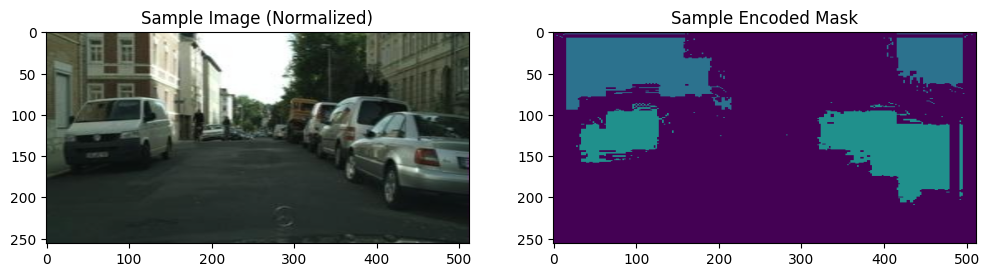

In [86]:
image_transforms = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Mask transforms: Convert PIL Image (mode 'L') to LongTensor (C,H,W)
mask_transforms = T.Compose([
    T.ToImage(), # Converts PIL (H,W) with uint8 values to Tensor (1,H,W) of torch.uint8
    T.ToDtype(torch.long, scale=False) # Converts to torch.long, no scaling for class IDs
])

def custom_collate_fn(batch):
    images, masks = zip(*batch)
    images = torch.stack(images, 0)
    # masks are (1, H, W) from mask_transforms, squeeze to (H,W) before stacking to (B,H,W)
    masks = torch.stack([m.squeeze(0) for m in masks], 0)
    return images, masks

train_dataset = CityscapesDataset(
    image_dir=TRAIN_DIR,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    class_info=CLASS_INFO,
    transform=image_transforms,
    mask_transform=mask_transforms # Using the defined mask_transforms
)

val_dataset = CityscapesDataset(
    image_dir=VAL_DIR,
    img_height=IMG_HEIGHT,
    img_width=IMG_WIDTH,
    class_info=CLASS_INFO,
    transform=image_transforms,
    mask_transform=mask_transforms # Using the defined mask_transforms
)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True, collate_fn=custom_collate_fn
)

print(f"Training samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

# Verify by displaying a sample
if len(train_dataset) > 0:
    try:
        sample_images, sample_masks = next(iter(train_loader))
        print(f"Sample images batch shape: {sample_images.shape}")
        print(f"Sample masks batch shape: {sample_masks.shape}")
        print(f"Sample masks data type: {sample_masks.dtype}")
        print(f"Min/Max mask values: {sample_masks.min()}, {sample_masks.max()}")
        unique_mask_values = torch.unique(sample_masks)
        print(f"Unique mask values in batch: {unique_mask_values}")

        # Visualize a sample
        img_vis = sample_images[0].permute(1, 2, 0).cpu().numpy() # CHW to HWC, ensure on CPU
        # Unnormalize for visualization
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_vis = std * img_vis + mean
        img_vis = np.clip(img_vis, 0, 1)

        mask_vis = sample_masks[0].cpu().numpy() # Ensure on CPU

        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(img_vis)
        ax[0].set_title("Sample Image (Normalized)")
        ax[1].imshow(mask_vis, cmap='viridis', vmin=0, vmax=NUM_CLASSES-1) # Use a colormap for ID mask
        ax[1].set_title("Sample Encoded Mask")
        plt.show()
    except Exception as e:
        print(f"Error fetching/displaying batch: {e}")
else:
    print("Train dataset is empty. Cannot verify loader.")

## b) Model Building (07 marks)

This section defines the neural network architectures for semantic segmentation. Two models are required: U-Net and FCN.

### Model 1: U-Net

This block implements the U-Net architecture, a popular convolutional neural network for biomedical image segmentation, also effective for general semantic segmentation.

*   **Helper Modules:**
    *   `DoubleConv`: A sequence of two convolutional layers, each followed by Batch Normalization and ReLU activation. This is a basic building block in U-Net.
    *   `Down`: Represents a downsampling step in the encoder path, consisting of a Max Pooling layer followed by a `DoubleConv` block.
    *   `Up`: Represents an upsampling step in the decoder path. It uses either bilinear upsampling (`nn.Upsample`) or transposed convolution (`nn.ConvTranspose2d`), followed by concatenation with the corresponding feature map from the encoder path (skip connection) and then a `DoubleConv` block. Padding is applied to ensure feature maps have compatible sizes for concatenation.
    *   `OutConv`: A final 1x1 convolutional layer that maps the feature channels from the last `Up` block to the number of output classes.
*   **`UNet(nn.Module)` Class:**
    *   `__init__`: Initializes the U-Net with the number of input channels (e.g., 3 for RGB images), number of output classes, and a flag for using bilinear upsampling. It constructs the encoder (downsampling path) and decoder (upsampling path) using the helper modules.
    *   `forward(self, x)`: Defines the forward pass. The input `x` goes through the encoder path, storing feature maps at each level for skip connections. Then, it goes through the decoder path, where upsampled features are concatenated with corresponding encoder features. The final output is produced by `OutConv`.
*   **Instantiation:** An instance of the `UNet` model is created, moved to the configured `DEVICE` (GPU or CPU), and a confirmation message is printed.

U-Net's architecture with skip connections allows it to combine low-level feature details with high-level semantic information, making it effective for precise localization in segmentation.


In [87]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels: mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels), nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.double_conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(nn.MaxPool2d(2), DoubleConv(in_channels, out_channels))
    def forward(self, x): return self.maxpool_conv(x)

class Up(nn.Module):
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2, diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x): return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels, self.n_classes, self.bilinear = n_channels, n_classes, bilinear
        self.inc = DoubleConv(n_channels, 64)
        self.down1, self.down2, self.down3 = Down(64, 128), Down(128, 256), Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)
    def forward(self, x):
        x1 = self.inc(x); x2 = self.down1(x1); x3 = self.down2(x2); x4 = self.down3(x3); x5 = self.down4(x4)
        x = self.up1(x5, x4); x = self.up2(x, x3); x = self.up3(x, x2); x = self.up4(x, x1)
        return self.outc(x)

unet_model = UNet(n_channels=3, n_classes=NUM_CLASSES).to(DEVICE)
print(f"U-Net model instantiated with {NUM_CLASSES} output classes.")

U-Net model instantiated with 9 output classes.



### Model 2: FCN (Fully Convolutional Network) with VGG16 Backbone

This block defines a Fully Convolutional Network (FCN) using a pre-trained VGG16 as its encoder, adapted from the provided Kaggle notebook. FCNs are a foundational architecture for semantic segmentation that replace fully connected layers in classification networks with convolutional layers to output spatial maps.

*   **`FCN_VGG16(nn.Module)` Class:**
    *   `__init__(self, num_classes, target_height, target_width)`:
        *   Takes the number of output classes and the target output dimensions for the segmentation map.
        *   Loads a VGG16 model pre-trained on ImageNet (`weights=VGG16_Weights.IMAGENET1K_V1`).
        *   Uses the `features` part of VGG16 as the `encoder`.
        *   Defines a `decoder` using a sequence of `nn.Conv2d` and `nn.ConvTranspose2d` layers. The VGG16 encoder typically downsamples the input by a factor of 32. The decoder aims to upsample these features back to the original image size (or target size). This specific decoder includes:
            *   Two 1x1 convolutional layers (sometimes called "pixel-wise convolutions") with ReLU and Dropout, common in FCN-8s/16s/32s architectures for refining features and preparing for classification.
            *   A final 1x1 convolutional layer to map feature channels to `num_classes`.
            *   A series of five `nn.ConvTranspose2d` layers, each with a stride of 2, to progressively upsample the feature map by a total factor of 2<sup>5</sup> = 32. ReLU activations are applied after each upsampling step except the last.
    *   `forward(self, x)`:
        *   Passes the input `x` through the `encoder`.
        *   Passes the encoded features through the `decoder` to get the segmentation map.
        *   Uses `nn.functional.interpolate` with `mode='bilinear'` as a final step to ensure the output segmentation map precisely matches the `target_height` and `target_width`. This is important if the `ConvTranspose2d` layers don't perfectly restore the original dimensions.
*   **Instantiation and Test:**
    *   An instance of `FCN_VGG16` is created with the specified `NUM_CLASSES` and target image dimensions, and moved to the `DEVICE`.
    *   A dummy input tensor is created and passed through the `fcn_model` to verify that the forward pass executes correctly and to check the output shape, which should be `[BATCH_SIZE, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH]`.

This FCN model leverages transfer learning by using a pre-trained VGG16 encoder, which can lead to better feature extraction and faster convergence, especially with limited training data.

In [88]:
class FCN_VGG16(nn.Module):
    def __init__(self, num_classes, target_height, target_width):
        super(FCN_VGG16, self).__init__()
        self.target_height = target_height
        self.target_width = target_width

        # Use VGG16 with pre-trained weights
        backbone = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
        self.encoder = backbone.features  # Extracts features from VGG16

        # Decoder with ConvTranspose2d layers
        # VGG16 features output size depends on input, typically H/32, W/32 with 512 channels
        # We need to upsample 32x. 2^5 = 32. So 5 upsampling layers.
        self.decoder = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=7, padding=3), # FCN-8s style full-conv layer
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Dropout2d(),
            nn.Conv2d(512, num_classes, kernel_size=1),
            # Upsample to the original image size (or target size)
            # VGG16 reduces size by 2^5 = 32. So we need ConvTranspose2d with stride 32
            # Or a series of ConvTranspose2d layers.
            # The Kaggle example used a simpler decoder, let's adapt that:
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1), # Upsample 2x
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1), # Upsample 4x
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1), # Upsample 8x
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1), # Upsample 16x
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)  # Upsample 32x
        )

    def forward(self, x):
        features = self.encoder(x)
        segmentation_map = self.decoder(features)
        # Ensure final output size matches target H, W
        segmentation_map = nn.functional.interpolate(
            segmentation_map,
            size=(self.target_height, self.target_width),
            mode='bilinear',
            align_corners=False
        )
        return segmentation_map

fcn_model = FCN_VGG16(num_classes=NUM_CLASSES, target_height=IMG_HEIGHT, target_width=IMG_WIDTH).to(DEVICE)
print(f"FCN-VGG16 model instantiated with {NUM_CLASSES} output classes, target HxW: {IMG_HEIGHT}x{IMG_WIDTH}.")

# Test FCN with a dummy input to check output shape
if BATCH_SIZE > 0:
    dummy_input = torch.randn(BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH).to(DEVICE)
    try:
        fcn_output = fcn_model(dummy_input)
        print(f"FCN dummy output shape: {fcn_output.shape}") # Expected: [B, NUM_CLASSES, IMG_HEIGHT, IMG_WIDTH]
    except Exception as e:
        print(f"Error during FCN dummy forward pass: {e}")

FCN-VGG16 model instantiated with 9 output classes, target HxW: 256x512.
FCN dummy output shape: torch.Size([8, 9, 256, 512])


In [99]:

# Output FCN-VGG16 Model Summary
print("\n--- FCN-VGG16 Model Summary ---")
# Define input size (channels, height, width)
input_size_fcn = (3, IMG_HEIGHT, IMG_WIDTH)
try:
    summary(fcn_model, input_size_fcn)
except Exception as e:
    print(f"Could not generate FCN-VGG16 summary: {e}")

# Test FCN with a dummy input to check output shape
if BATCH_SIZE > 0:
    dummy_input = torch.randn(BATCH_SIZE, 3, IMG_HEIGHT, IMG_WIDTH).to(DEVICE)
    try:
        fcn_output = fcn_model(dummy_input)
        print(f"FCN dummy output shape: {fcn_output.shape}")
    except Exception as e:
        print(f"Error during FCN dummy forward pass: {e}")


--- FCN-VGG16 Model Summary ---
Could not generate FCN-VGG16 summary: name 'summary' is not defined
FCN dummy output shape: torch.Size([8, 9, 256, 512])


### Loss Functions

This block defines the loss functions that will be used to train the segmentation models. The problem statement requires CrossEntropyLoss and DiceLoss.

*   **`ce_loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)`:**
    *   Standard CrossEntropyLoss is suitable for multi-class pixel-wise classification tasks.
    *   `ignore_index=IGNORE_INDEX` ensures that pixels belonging to the "unlabeled" class (or any other specified ignored class) do not contribute to the loss calculation.
*   **`DiceLoss(nn.Module)` Class:**
    *   A custom implementation of Dice Loss. Dice Loss is often used in segmentation because it directly optimizes the Dice Coefficient (F1 score for segmentation), which is a common evaluation metric and can handle class imbalance better than CrossEntropyLoss alone.
    *   `__init__`: Initializes with a `smooth` factor (to prevent division by zero), an `ignore_index`, and a flag `apply_softmax` (True by default, as models output logits).
    *   `forward(self, logits, targets)`:
        *   Applies softmax to the input `logits` to get probabilities if `apply_softmax` is true.
        *   Iterates through each class (except `ignore_index`).
        *   For each class `c`, it extracts the probability map `p_c` and creates a one-hot target map `t_c`.
        *   Calculates the intersection (`p_c * t_c`).sum() and the sum of probabilities/targets (`p_c.sum() + t_c.sum()`).
        *   Computes the Dice score for class `c` using the formula `(2. * intersection + smooth) / (union_sum + smooth)`.
        *   The loss for class `c` is `1. - dice_score_c`.
        *   The total Dice Loss is the average of per-class losses over all valid (non-ignored) classes.
*   **`dice_loss_fn = DiceLoss(ignore_index=IGNORE_INDEX)`:**
    *   An instance of the custom `DiceLoss` class.
*   **`combined_loss_fn(logits, targets, ce_weight=0.5, dice_weight=0.5)`:**
    *   A function that computes a weighted sum of CrossEntropyLoss and DiceLoss.
    *   `ce_weight` and `dice_weight` control the contribution of each loss component. This combination often leads to better performance than using either loss function alone, as it balances pixel-wise accuracy with overlap maximization.
*   A confirmation message is printed indicating that the loss functions have been defined.


In [89]:
ce_loss_fn = nn.CrossEntropyLoss(ignore_index=IGNORE_INDEX)

class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0, ignore_index=None, apply_softmax=True):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
        self.apply_softmax = apply_softmax

    def forward(self, logits, targets):
        if self.apply_softmax: probs = torch.softmax(logits, dim=1)
        else: probs = logits

        num_classes = probs.shape[1]
        loss = 0.0
        actual_classes_counted = 0

        for c in range(num_classes):
            if self.ignore_index is not None and c == self.ignore_index:
                continue

            p_c = probs[:, c, :, :]
            t_c = (targets == c).float()

            intersection = (p_c * t_c).sum()
            union_sum = p_c.sum() + t_c.sum()

            dice_score_c = (2. * intersection + self.smooth) / (union_sum + self.smooth)
            loss += (1. - dice_score_c)
            actual_classes_counted +=1

        return loss / actual_classes_counted if actual_classes_counted > 0 else torch.tensor(0.0, device=logits.device)

dice_loss_fn = DiceLoss(ignore_index=IGNORE_INDEX)

def combined_loss_fn(logits, targets, ce_weight=0.5, dice_weight=0.5):
    ce = ce_loss_fn(logits, targets)
    dice = dice_loss_fn(logits, targets)
    return ce_weight * ce + dice_weight * dice

print("Loss functions defined: CrossEntropyLoss, DiceLoss, CombinedLoss.")

Loss functions defined: CrossEntropyLoss, DiceLoss, CombinedLoss.


## c) Training and Evaluation (06 marks)

This section covers the setup for training the models and evaluating their performance using key segmentation metrics.

### Custom Dice Coefficient Metric Accumulator

This block defines the `DiceCoefficientAccumulator` class. Since the user requested not to use `torchmetrics.Dice`, this custom class is implemented to calculate the Dice coefficient per epoch.

*   **`__init__(self, num_classes, ignore_index=None, smooth=1.0)`:**
    *   Initializes the accumulator with the number of classes, an optional `ignore_index` for classes to exclude from calculation (like "unlabeled"), and a `smooth` factor to prevent division by zero in the Dice formula.
    *   Internal tensors for `intersections`, `total_pixels_pred`, and `total_pixels_target` are initialized on the CPU by default.
*   **`reset(self)`:**
    *   Resets the accumulated counts (`intersections`, `total_pixels_pred`, `total_pixels_target`) to zero. This is called at the beginning of each epoch.
*   **`to(self, device)`:**
    *   A utility method to move the internal accumulator tensors to the specified `device` (e.g., GPU if training on GPU) and then resets them.
*   **`update(self, preds_argmax, targets)`:**
    *   Takes a batch of predicted class maps (`preds_argmax`, shape B,H,W, after applying `argmax` to model logits) and ground truth masks (`targets`, shape B,H,W).
    *   Ensures inputs are on the same device as the accumulators.
    *   Iterates through each class (except `ignore_index`).
    *   For each class `c`:
        *   Creates boolean masks `pred_c` (where prediction is `c`) and `target_c` (where ground truth is `c`).
        *   Calculates the intersection (True Positives for class `c`) as `(pred_c & target_c).sum()`.
        *   Calculates the total pixels predicted as class `c` (True Positives + False Positives).
        *   Calculates the total pixels actually belonging to class `c` in the ground truth (True Positives + False Negatives).
        *   Accumulates these counts in the respective class-wise tensors.
*   **`compute(self)`:**
    *   Calculates the per-class Dice coefficients using the accumulated counts and the Dice formula: `(2 * TP + smooth) / ((TP + FP) + (TP + FN) + smooth)`.
    *   Calculates the macro-averaged Dice score by averaging the Dice scores of all valid (non-ignored) classes.
    *   Returns the macro Dice score (a scalar) and a list of per-class Dice scores.
*   A confirmation message is printed. This accumulator allows for robust epoch-wise calculation of the Dice coefficient.


In [90]:
class DiceCoefficientAccumulator:
    def __init__(self, num_classes, ignore_index=None, smooth=1.0):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.smooth = smooth
        self.intersections = torch.zeros(num_classes, dtype=torch.float64)
        self.total_pixels_pred = torch.zeros(num_classes, dtype=torch.float64)
        self.total_pixels_target = torch.zeros(num_classes, dtype=torch.float64)
        self.device = 'cpu'

    def reset(self):
        self.intersections = torch.zeros(self.num_classes, dtype=torch.float64, device=self.device)
        self.total_pixels_pred = torch.zeros(self.num_classes, dtype=torch.float64, device=self.device)
        self.total_pixels_target = torch.zeros(self.num_classes, dtype=torch.float64, device=self.device)

    def to(self, device):
        self.device = device
        self.reset()
        return self

    def update(self, preds_argmax, targets):
        preds_argmax = preds_argmax.to(self.device)
        targets = targets.to(self.device)
        for c in range(self.num_classes):
            if self.ignore_index is not None and c == self.ignore_index:
                continue
            pred_c = (preds_argmax == c)
            target_c = (targets == c)
            self.intersections[c] += (pred_c & target_c).sum().float()
            self.total_pixels_pred[c] += pred_c.sum().float()
            self.total_pixels_target[c] += target_c.sum().float()

    def compute(self):
        per_class_dice = torch.zeros(self.num_classes, dtype=torch.float32, device=self.device)
        valid_dice_scores_for_macro = []
        for c in range(self.num_classes):
            if self.ignore_index is not None and c == self.ignore_index:
                per_class_dice[c] = float('nan')
                continue
            dice_c_val = (2. * self.intersections[c] + self.smooth) / \
                         (self.total_pixels_pred[c] + self.total_pixels_target[c] + self.smooth)
            per_class_dice[c] = dice_c_val
            if not torch.isnan(dice_c_val): # Only average valid dice scores
                 valid_dice_scores_for_macro.append(dice_c_val.item())

        macro_dice = sum(valid_dice_scores_for_macro) / len(valid_dice_scores_for_macro) if valid_dice_scores_for_macro else 0.0
        return macro_dice, per_class_dice.cpu().tolist()

print("DiceCoefficientAccumulator defined.")

DiceCoefficientAccumulator defined.


### Evaluation Metrics Setup (mIoU and Accuracy)

This block configures metrics for Mean Intersection over Union (mIoU) and Pixel Accuracy using the `torchmetrics` library.

*   **mIoU (Jaccard Index):**
    *   `miou_metric`: An instance of `JaccardIndex` from `torchmetrics`, configured for "multiclass" task, with the total `NUM_CLASSES`, the `IGNORE_INDEX`, and `average='macro'` to compute the mean IoU across all valid classes.
    *   `miou_metric_per_class`: Another `JaccardIndex` instance, but with `average='none'` to get per-class IoU scores.
*   **Pixel Accuracy:**
    *   `pixel_accuracy_metric_overall`: An instance of `Accuracy` from `torchmetrics`, configured for "multiclass", with `NUM_CLASSES`, `IGNORE_INDEX`, and `average='micro'` to compute the overall pixel accuracy (total correctly classified pixels / total valid pixels).
    *   `pixel_accuracy_metric_per_class`: Another `Accuracy` instance with `average='none'` to get per-class pixel accuracies.
*   **`torchmetrics_collection`:**
    *   A dictionary to group all the `torchmetrics` instances for easier management during training and evaluation loops.
*   **Helper Functions:**
    *   `reset_torchmetrics(metrics_coll)`: Iterates through a collection of metrics and calls their `reset()` method, typically at the start of each epoch.
    *   `get_torchmetrics_results(metrics_coll, class_names_list, ignore_idx)`: Computes the final values for the accumulated `torchmetrics` (mIoU, Pixel Accuracy - overall and per-class) and returns them in a structured dictionary format.
*   A confirmation message is printed.

In [91]:
miou_metric = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, average='macro')
miou_metric_per_class = JaccardIndex(task="multiclass", num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, average='none')
pixel_accuracy_metric_overall = Accuracy(task="multiclass", num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, average='micro')
pixel_accuracy_metric_per_class = Accuracy(task="multiclass", num_classes=NUM_CLASSES, ignore_index=IGNORE_INDEX, average='none')

torchmetrics_collection = {
    "mIoU": miou_metric, "mIoU_per_class": miou_metric_per_class,
    "PixelAccuracy(Overall)": pixel_accuracy_metric_overall, "PixelAccuracy_per_class": pixel_accuracy_metric_per_class,
}

def reset_torchmetrics(metrics_coll):
    for metric in metrics_coll.values(): metric.reset()

def get_torchmetrics_results(metrics_coll, class_names_list, ignore_idx):
    results = {"mIoU": metrics_coll["mIoU"].compute().item(),
               "PixelAccuracy(Overall)": metrics_coll["PixelAccuracy(Overall)"].compute().item()}
    per_class_results = {}
    iou_pc_tensor = metrics_coll["mIoU_per_class"].compute().cpu()
    acc_pc_tensor = metrics_coll["PixelAccuracy_per_class"].compute().cpu()
    valid_indices = [i for i in range(NUM_CLASSES) if i != ignore_idx]
    per_class_results["iou_per_class"] = {class_names_list[i]: iou_pc_tensor[i].item() for i in valid_indices if i < len(iou_pc_tensor)}
    per_class_results["accuracy_per_class"] = {class_names_list[i]: acc_pc_tensor[i].item() for i in valid_indices if i < len(acc_pc_tensor)}
    return results, per_class_results

print("Torchmetrics (mIoU, Accuracy) configured.")

Torchmetrics (mIoU, Accuracy) configured.


### Training and Validation Loops

This block defines the core functions for training one epoch (`train_one_epoch`) and evaluating the model (`evaluate_model`).

*   **`train_one_epoch(...)`:**
    *   Sets the `model` to training mode (`model.train()`).
    *   Initializes `total_loss` and resets all epoch-specific metrics (both `torchmetrics` and the custom `DiceCoefficientAccumulator`).
    *   Iterates through the `loader` (training data loader) using `tqdm` for a progress bar.
    *   For each batch of `images` and `masks`:
        *   Moves data to the specified `device`.
        *   Clears gradients (`optimizer.zero_grad()`).
        *   Performs a forward pass: `outputs = model(images)`. Handles cases where the model might return a dictionary (e.g., DeepLabV3 with auxiliary outputs) by extracting the main output.
        *   Calculates the `loss` using the provided `criterion`.
        *   Performs backpropagation (`loss.backward()`).
        *   Updates model weights (`optimizer.step()`).
        *   Accumulates the `total_loss`.
        *   Computes `preds_argmax` from the model outputs.
        *   Updates all `torchmetrics_epoch` and the `dice_accumulator_epoch` with the predictions and ground truth masks.
        *   Updates the progress bar postfix with the current batch loss.
    *   Calculates the average training `loss` for the epoch.
    *   Computes the final epoch metrics from the `torchmetrics_epoch` and `dice_accumulator_epoch`.
    *   Returns the average training loss and a dictionary of epoch metrics.
*   **`evaluate_model(...)`:**
    *   Sets the `model` to evaluation mode (`model.eval()`).
    *   Similar structure to `train_one_epoch` but without gradient calculations (`with torch.no_grad():`) and optimizer steps.
    *   Iterates through the `loader` (validation data loader).
    *   Calculates and accumulates `total_loss` and updates metrics.
    *   Returns the average validation loss, a dictionary of overall epoch metrics, and a dictionary of per-class validation metrics.


In [92]:
def train_one_epoch(model, loader, optimizer, criterion, device, torchmetrics_epoch, dice_accumulator_epoch):
    model.train()
    total_loss = 0.0
    reset_torchmetrics(torchmetrics_epoch)
    dice_accumulator_epoch.reset()

    progress_bar = tqdm(loader, desc="Training", leave=False)
    for images, masks in progress_bar:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        main_output = outputs['out'] if isinstance(outputs, dict) else outputs

        loss = criterion(main_output, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)

        preds_argmax = torch.argmax(main_output, dim=1)
        for metric_fn in torchmetrics_epoch.values(): metric_fn.update(preds_argmax, masks)
        dice_accumulator_epoch.update(preds_argmax, masks)
        progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    epoch_metrics_results, _ = get_torchmetrics_results(torchmetrics_epoch, CLASS_NAMES, IGNORE_INDEX)
    macro_dice, _ = dice_accumulator_epoch.compute()
    epoch_metrics_results["Dice"] = macro_dice
    return avg_loss, epoch_metrics_results

def evaluate_model(model, loader, criterion, device, torchmetrics_epoch, dice_accumulator_epoch):
    model.eval()
    total_loss = 0.0
    reset_torchmetrics(torchmetrics_epoch)
    dice_accumulator_epoch.reset()

    progress_bar = tqdm(loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for images, masks in progress_bar:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            main_output = outputs['out'] if isinstance(outputs, dict) else outputs
            loss = criterion(main_output, masks)
            total_loss += loss.item() * images.size(0)
            preds_argmax = torch.argmax(main_output, dim=1)
            for metric_fn in torchmetrics_epoch.values(): metric_fn.update(preds_argmax, masks)
            dice_accumulator_epoch.update(preds_argmax, masks)
            progress_bar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    epoch_metrics_results, per_class_torchmetrics = get_torchmetrics_results(torchmetrics_epoch, CLASS_NAMES, IGNORE_INDEX)
    macro_dice, per_class_dice_list = dice_accumulator_epoch.compute()
    epoch_metrics_results["Dice"] = macro_dice

    per_class_results_final = per_class_torchmetrics
    valid_indices = [i for i in range(NUM_CLASSES) if i != IGNORE_INDEX]
    per_class_results_final["dice_per_class"] = {
        CLASS_NAMES[i]: per_class_dice_list[i] for i in valid_indices if i < len(per_class_dice_list)
    }
    return avg_loss, epoch_metrics_results, per_class_results_final


### Main Training Function

This block defines the `train_model_main` function, which orchestrates the entire training process over multiple epochs for a given model.

*   **`train_model_main(...)`:**
    *   Takes the model, model name (for logging), data loaders, optimizer, loss criterion, number of epochs, device, base `torchmetrics` collection, and the `DiceCoefficientAccumulator` class as input.
    *   Initializes a `history` dictionary to store training and validation metrics for each epoch (losses, mIoU, Dice, Pixel Accuracy, and per-class IoU/Dice for validation).
    *   Creates separate instances of `torchmetrics` and `DiceCoefficientAccumulator` for training and validation phases by cloning the base metric objects and moving them to the correct `device`. This prevents state interference between training and validation metric calculations.
    *   Prints a message indicating the start of training for the specified `model_name`.
    *   Loops for the specified `num_epochs`:
        *   Prints the current epoch number.
        *   Calls `train_one_epoch` to train the model for one epoch and appends the returned loss and metrics to the `history` dictionary. Prints the training metrics.
        *   Calls `evaluate_model` to evaluate the model on the validation set and appends the returned loss, overall metrics, and per-class metrics to the `history` dictionary. Prints the validation metrics.
    *   Prints a message indicating the end of training.
    *   Returns the `history` dictionary containing all recorded metrics.

This function provides a standardized way to train any model with the defined data and evaluation setup.


In [93]:
def train_model_main(model, model_name, train_loader, val_loader, optimizer, criterion, num_epochs, device, base_torchmetrics, base_dice_accumulator_cls):
    history = {key: [] for key in ['train_loss', 'val_loss', 'train_mIoU', 'val_mIoU',
                                   'train_dice', 'val_dice', 'train_pix_acc', 'val_pix_acc',
                                   'val_per_class_iou', 'val_per_class_dice']}

    train_tm = {name: metric.clone().to(device) for name, metric in base_torchmetrics.items()}
    val_tm = {name: metric.clone().to(device) for name, metric in base_torchmetrics.items()}
    train_da = base_dice_accumulator_cls(NUM_CLASSES, IGNORE_INDEX).to(device)
    val_da = base_dice_accumulator_cls(NUM_CLASSES, IGNORE_INDEX).to(device)

    print(f"\n--- Training {model_name} for {num_epochs} epochs ---")
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_loss, train_epoch_metrics = train_one_epoch(model, train_loader, optimizer, criterion, device, train_tm, train_da)
        history['train_loss'].append(train_loss)
        history['train_mIoU'].append(train_epoch_metrics.get("mIoU", float('nan')))
        history['train_dice'].append(train_epoch_metrics.get("Dice", float('nan')))
        history['train_pix_acc'].append(train_epoch_metrics.get("PixelAccuracy(Overall)", float('nan')))
        print(f"Train Loss: {train_loss:.4f} | mIoU: {train_epoch_metrics.get('mIoU', 0):.4f} | Dice: {train_epoch_metrics.get('Dice', 0):.4f} | PixAcc: {train_epoch_metrics.get('PixelAccuracy(Overall)', 0):.4f}")

        val_loss, val_epoch_metrics, val_per_class_res = evaluate_model(model, val_loader, criterion, device, val_tm, val_da)
        history['val_loss'].append(val_loss)
        history['val_mIoU'].append(val_epoch_metrics.get("mIoU", float('nan')))
        history['val_dice'].append(val_epoch_metrics.get("Dice", float('nan')))
        history['val_pix_acc'].append(val_epoch_metrics.get("PixelAccuracy(Overall)", float('nan')))
        history['val_per_class_iou'].append(val_per_class_res.get("iou_per_class", {}))
        history['val_per_class_dice'].append(val_per_class_res.get("dice_per_class", {}))
        print(f"Val Loss: {val_loss:.4f}   | mIoU: {val_epoch_metrics.get('mIoU', 0):.4f} | Dice: {val_epoch_metrics.get('Dice', 0):.4f} | PixAcc: {val_epoch_metrics.get('PixelAccuracy(Overall)', 0):.4f}")

    print(f"--- Training of {model_name} finished ---")
    return history

### Training the Models

This block executes the actual training for the two required models: U-Net and FCN-VGG16.

*   **Dataset Check:**
    *   First, it checks if `train_dataset` or `val_dataset` are empty. If they are, it skips training and prints a message. It also creates a `dummy_history` structure for U-Net and FCN so that subsequent plotting cells can run without error (though they will show zero values). This is useful for demonstrating the pipeline even without a fully populated dataset.
*   **U-Net Training:**
    *   If datasets are not empty:
        *   An Adam optimizer (`optimizer_unet`) is created for the `unet_model` parameters with the defined `LEARNING_RATE`.
        *   The `train_model_main` function is called with the `unet_model`, its name, data loaders, optimizer, the `combined_loss_fn`, number of epochs, device, and the base metric collectors (`torchmetrics_collection`, `DiceCoefficientAccumulator`).
        *   The returned `unet_history` is stored.
        *   The state dictionary of the trained `unet_model` is saved to a file named `unet_cityscapes_model.pth`.

In [94]:
# Ensure dataset is not empty
if len(train_dataset) == 0 or len(val_dataset) == 0:
    print("Datasets are empty. Skipping model training.")
    # Create dummy history for plotting if needed for demo
    dummy_history_val = {CLASS_NAMES[i]:0.0 for i in range(NUM_CLASSES) if i != IGNORE_INDEX}
    create_dummy_history = lambda: {key: ([0.0]*NUM_EPOCHS if 'per_class' not in key else [dummy_history_val]*NUM_EPOCHS)
                                     for key in ['train_loss', 'val_loss', 'train_mIoU', 'val_mIoU',
                                                 'train_dice', 'val_dice', 'train_pix_acc', 'val_pix_acc',
                                                 'val_per_class_iou', 'val_per_class_dice']}
    unet_history = create_dummy_history()
    fcn_history = create_dummy_history()
else:
    # Training U-Net
    optimizer_unet = optim.Adam(unet_model.parameters(), lr=LEARNING_RATE)
    unet_history = train_model_main(
        unet_model, "U-Net", train_loader, val_loader,
        optimizer_unet, combined_loss_fn, NUM_EPOCHS, DEVICE,
        torchmetrics_collection, DiceCoefficientAccumulator
    )
    torch.save(unet_model.state_dict(), "unet_cityscapes_model.pth")



--- Training U-Net for 3 epochs ---

Epoch 1/3


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Train Loss: 0.6237 | mIoU: 0.2133 | Dice: 0.0859 | PixAcc: 0.9312


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.5225   | mIoU: 0.3057 | Dice: 0.1088 | PixAcc: 0.9704

Epoch 2/3


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Train Loss: 0.5046 | mIoU: 0.3158 | Dice: 0.0909 | PixAcc: 0.9796


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.5083   | mIoU: 0.3753 | Dice: 0.0932 | PixAcc: 0.9781

Epoch 3/3


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Train Loss: 0.4848 | mIoU: 0.3218 | Dice: 0.0960 | PixAcc: 0.9870


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.4975   | mIoU: 0.3751 | Dice: 0.1048 | PixAcc: 0.9776
--- Training of U-Net finished ---



*   **FCN-VGG16 Training:**
    *   Similarly, an Adam optimizer (`optimizer_fcn`) is created for the `fcn_model`.
    *   `train_model_main` is called for the `fcn_model`.
    *   The returned `fcn_history` is stored.
    *   The state dictionary of the trained `fcn_model` is saved to `fcn_vgg16_cityscapes_model.pth`.

This block is where the computationally intensive training happens. The number of epochs (`NUM_EPOCHS`) is currently set low (10) for faster demonstration; for good results, this would typically be much higher.

In [95]:

    # Training FCN-VGG16
    optimizer_fcn = optim.Adam(fcn_model.parameters(), lr=LEARNING_RATE)
    fcn_history = train_model_main(
        fcn_model, "FCN-VGG16", train_loader, val_loader,
        optimizer_fcn, combined_loss_fn, NUM_EPOCHS, DEVICE,
        torchmetrics_collection, DiceCoefficientAccumulator
    )
    torch.save(fcn_model.state_dict(), "fcn_vgg16_cityscapes_model.pth")


--- Training FCN-VGG16 for 3 epochs ---

Epoch 1/3


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e26ccc1b380>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e26ccc1b380>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 15

Training:   0%|          | 0/372 [00:02<?, ?it/s]

^    ^assert self._parent_pid == os.getpid(), 'can only test a child process'^^
^ ^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
                 ^  ^ ^ ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError^
: can only test a child processAssertionError
: can only test a child processException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e26ccc1b380>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^

Train Loss: 0.8385 | mIoU: 0.0958 | Dice: 0.0244 | PixAcc: 0.7168


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.6272   | mIoU: 0.2212 | Dice: 0.3987 | PixAcc: 0.8438

Epoch 2/3


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Train Loss: 0.5382 | mIoU: 0.3939 | Dice: 0.0511 | PixAcc: 0.9389


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.4936   | mIoU: 0.4928 | Dice: 0.3166 | PixAcc: 0.9951

Epoch 3/3


Training:   0%|          | 0/372 [00:00<?, ?it/s]

Train Loss: 0.4857 | mIoU: 0.3934 | Dice: 0.0508 | PixAcc: 0.9946


Evaluating:   0%|          | 0/63 [00:00<?, ?it/s]

Val Loss: 0.4869   | mIoU: 0.4941 | Dice: 0.2364 | PixAcc: 0.9957
--- Training of FCN-VGG16 finished ---


# the warning is related to class inheritance. Model has been trained and evaluation is given


## d) Results Visualization (04 marks)

This section is dedicated to visualizing the results obtained from the training process.

### Plotting Training Curves (Loss, mIoU, Dice)

This block defines and uses a function to plot the training and validation metrics (Loss, mIoU, Dice Coefficient) against epochs.

*   **`plot_training_curves(history, model_name)` Function:**
    *   Takes the `history` dictionary (as returned by `train_model_main`) and the `model_name` as input.
    *   Creates a figure with three subplots arranged horizontally.
    *   **Subplot 1 (Loss):** Plots training loss and validation loss vs. epochs.
    *   **Subplot 2 (mIoU):** Plots training mIoU and validation mIoU vs. epochs. Sets y-axis limits to [0,1].
    *   **Subplot 3 (Dice Coefficient):** Plots training Dice coefficient and validation Dice coefficient vs. epochs. Sets y-axis limits to [0,1].
    *   Each subplot includes labels, a title, a legend, and a grid for better readability.
    *   `plt.tight_layout()` adjusts subplot parameters for a tight layout.
    *   `plt.show()` displays the plots.
*   **Function Calls:**
    *   The `plot_training_curves` function is called for `unet_history` and `fcn_history` (if they exist and contain data, i.e., if training was not skipped).

These plots are essential for analyzing the training process, checking for convergence, identifying potential overfitting (e.g., if training loss decreases while validation loss increases), and comparing the overall performance trends of the models.

### Class-wise Performance (Bar Charts)

This block defines and uses a function to create bar charts showing the per-class mIoU and Dice coefficient from the last validation epoch.

*   **`plot_class_wise_performance(history, model_name)` Function:**
    *   Takes the `history` dictionary and `model_name` as input.
    *   Checks if per-class IoU data is available in the history; if not, it prints a message and returns.
    *   Extracts the per-class IoU (`last_epoch_iou_dict`) and per-class Dice (`last_epoch_dice_dict`) from the last epoch of the validation history.
    *   Retrieves class labels and corresponding metric values from these dictionaries.
    *   Creates a figure with two subplots arranged horizontally.
    *   **Subplot 1 (Class-wise mIoU):** Displays a bar chart of mIoU for each class.
    *   **Subplot 2 (Class-wise Dice):** Displays a bar chart of Dice coefficient for each class.
    *   Each bar chart includes x-axis labels (class names, rotated for readability), y-axis labels, a title, y-axis limits [0,1], and a grid.
    *   Value labels are added on top of each bar to show the exact metric value.
    *   `plt.tight_layout()` is used for better spacing.
    *   `plt.show()` displays the plots.
*   **Function Calls:**
    *   The `plot_class_wise_performance` function is called for `unet_history` and `fcn_history` (if they exist and contain data).

These bar charts provide a granular view of how well each model performs on individual semantic classes, which is useful for identifying classes that are easy or difficult for the model to segment.


--- Plotting U-Net Training Curves ---


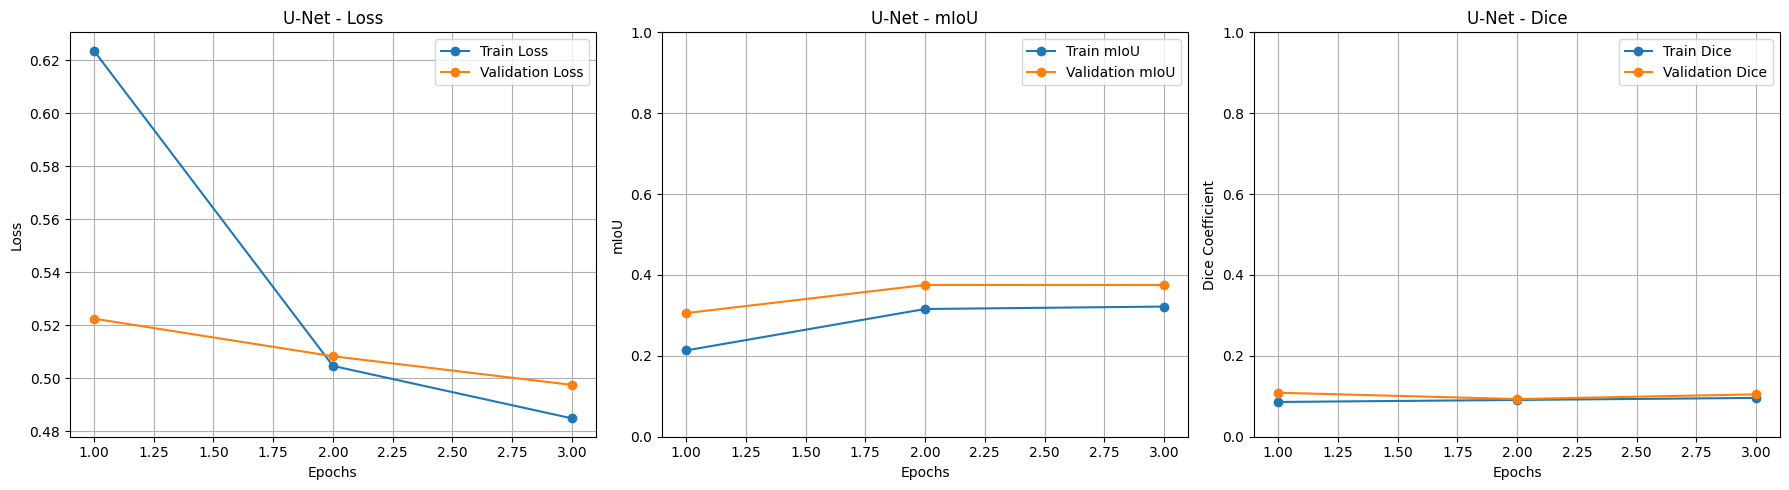


--- Plotting FCN-VGG16 Training Curves ---


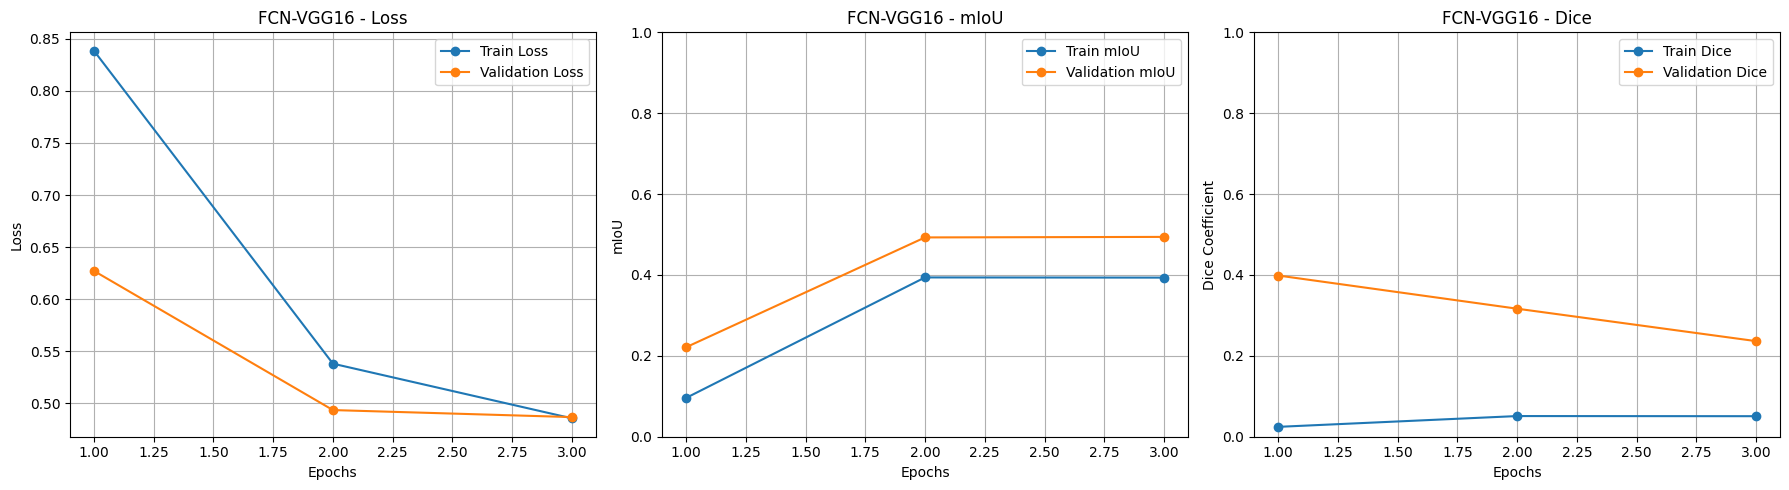

In [96]:
def plot_training_curves(history, model_name):
    epochs_range = range(1, NUM_EPOCHS + 1)
    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], 'o-', label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], 'o-', label='Validation Loss')
    plt.xlabel('Epochs'); plt.ylabel('Loss'); plt.title(f'{model_name} - Loss'); plt.legend(); plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['train_mIoU'], 'o-', label='Train mIoU')
    plt.plot(epochs_range, history['val_mIoU'], 'o-', label='Validation mIoU')
    plt.xlabel('Epochs'); plt.ylabel('mIoU'); plt.title(f'{model_name} - mIoU'); plt.legend(); plt.grid(True); plt.ylim(0,1)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['train_dice'], 'o-', label='Train Dice')
    plt.plot(epochs_range, history['val_dice'], 'o-', label='Validation Dice')
    plt.xlabel('Epochs'); plt.ylabel('Dice Coefficient'); plt.title(f'{model_name} - Dice'); plt.legend(); plt.grid(True); plt.ylim(0,1)

    plt.tight_layout()
    plt.show()

print("\n--- Plotting U-Net Training Curves ---")
if unet_history and unet_history['train_loss']: plot_training_curves(unet_history, "U-Net")

print("\n--- Plotting FCN-VGG16 Training Curves ---")
if fcn_history and fcn_history['train_loss']: plot_training_curves(fcn_history, "FCN-VGG16")


--- Plotting U-Net Class-wise Performance ---


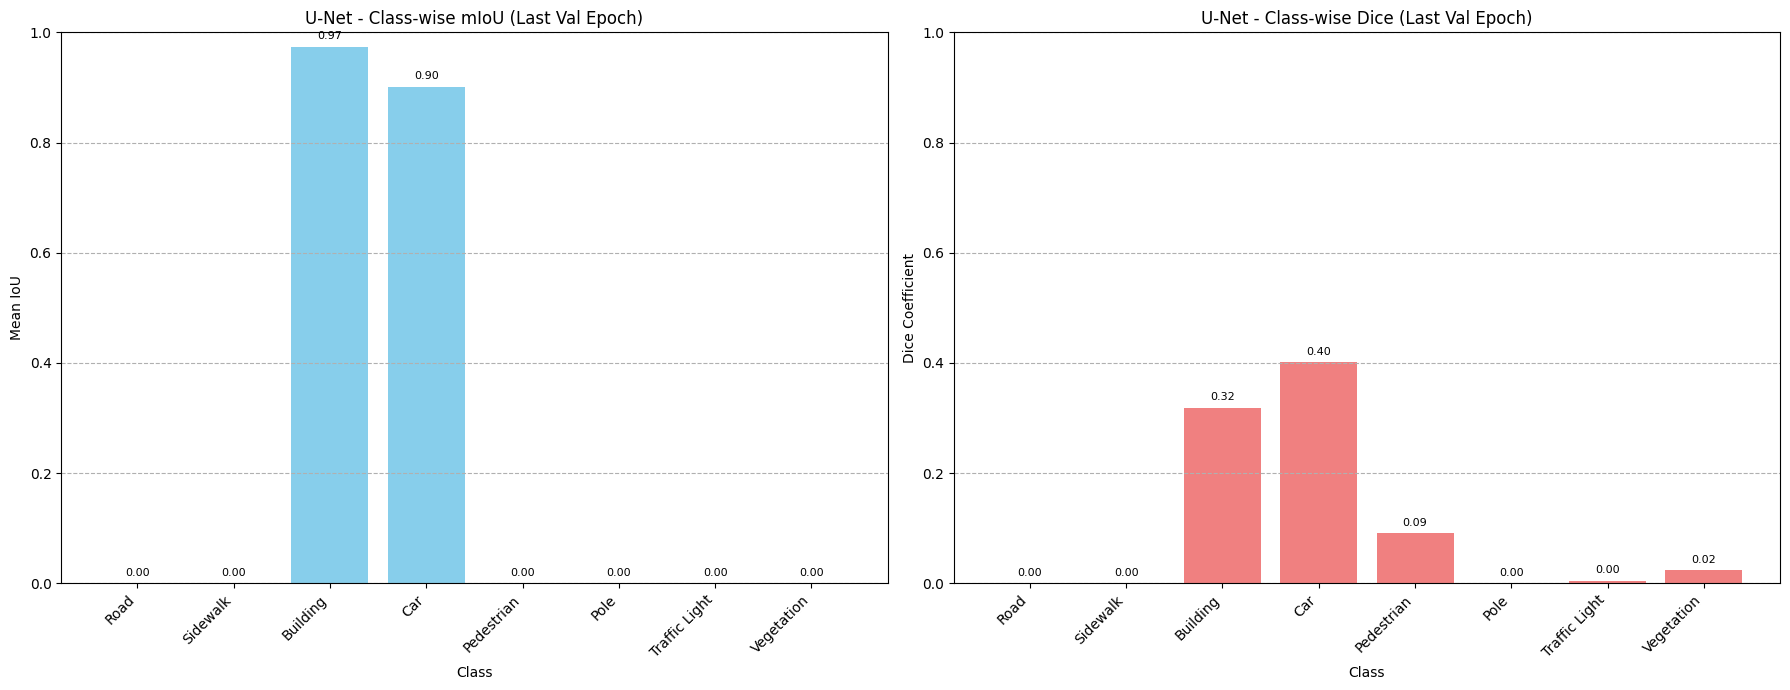


--- Plotting FCN-VGG16 Class-wise Performance ---


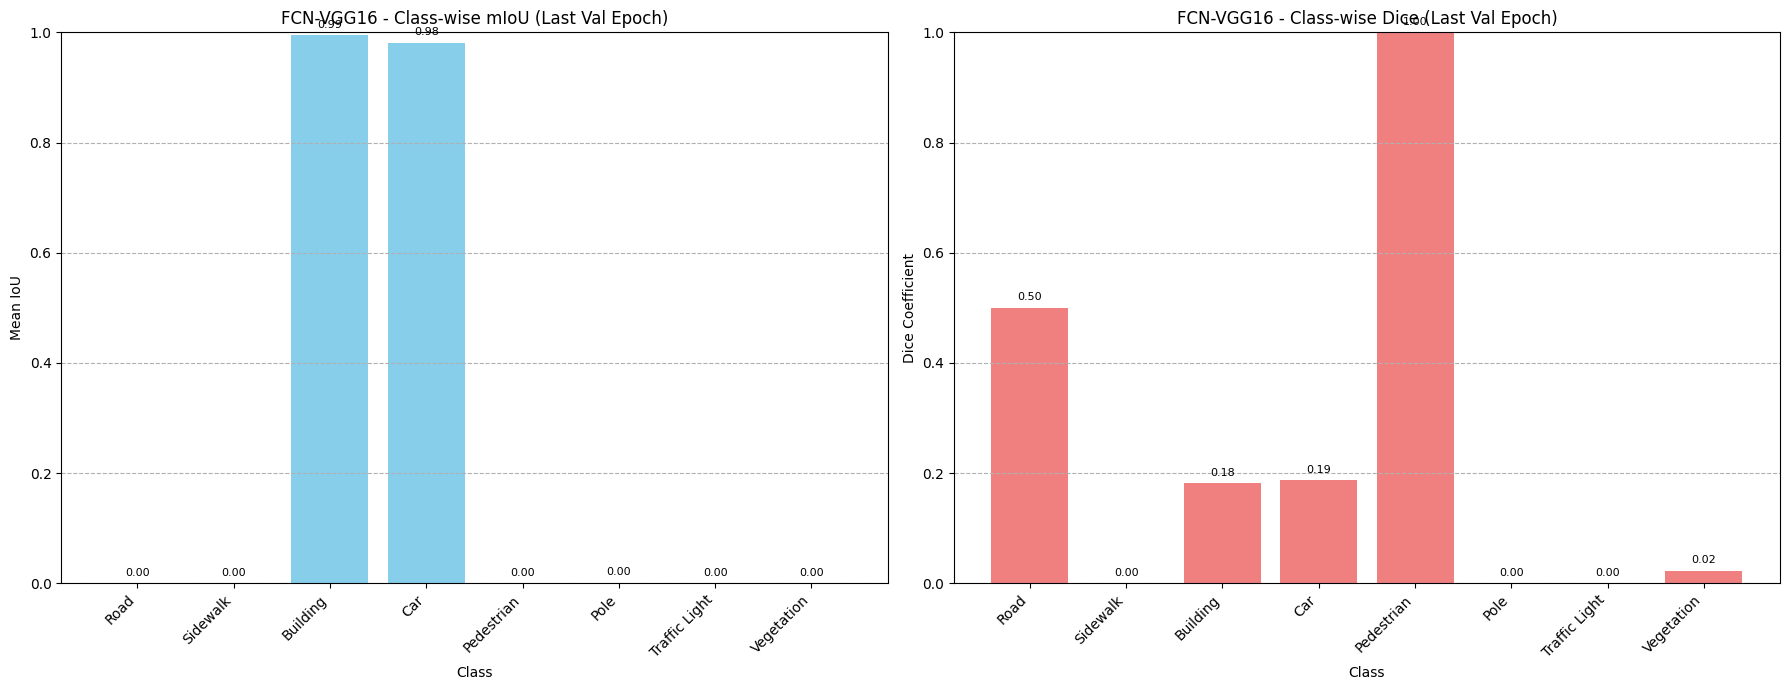

In [97]:
def plot_class_wise_performance(history, model_name):
    if not history['val_per_class_iou'] or not history['val_per_class_iou'][-1]:
        print(f"No per-class IoU data to plot for {model_name}.")
        return

    last_epoch_iou_dict = history['val_per_class_iou'][-1]
    last_epoch_dice_dict = history['val_per_class_dice'][-1]

    class_labels_iou = list(last_epoch_iou_dict.keys())
    iou_values = [last_epoch_iou_dict.get(lbl, 0) for lbl in class_labels_iou]
    class_labels_dice = list(last_epoch_dice_dict.keys())
    dice_values = [last_epoch_dice_dict.get(lbl, 0) for lbl in class_labels_dice]

    plt.figure(figsize=(18, 7))
    plt.subplot(1, 2, 1)
    bars_iou = plt.bar(class_labels_iou, iou_values, color='skyblue')
    plt.xlabel("Class"); plt.ylabel("Mean IoU")
    plt.title(f"{model_name} - Class-wise mIoU (Last Val Epoch)")
    plt.xticks(rotation=45, ha='right'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--')
    for bar in bars_iou:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

    plt.subplot(1, 2, 2)
    bars_dice = plt.bar(class_labels_dice, dice_values, color='lightcoral')
    plt.xlabel("Class"); plt.ylabel("Dice Coefficient")
    plt.title(f"{model_name} - Class-wise Dice (Last Val Epoch)")
    plt.xticks(rotation=45, ha='right'); plt.ylim(0, 1); plt.grid(axis='y', linestyle='--')
    for bar in bars_dice:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

print("\n--- Plotting U-Net Class-wise Performance ---")
if unet_history and unet_history['val_per_class_iou']: plot_class_wise_performance(unet_history, "U-Net")

print("\n--- Plotting FCN-VGG16 Class-wise Performance ---")
if fcn_history and fcn_history['val_per_class_iou']: plot_class_wise_performance(fcn_history, "FCN-VGG16")


--- Visualizing U-Net Predictions ---


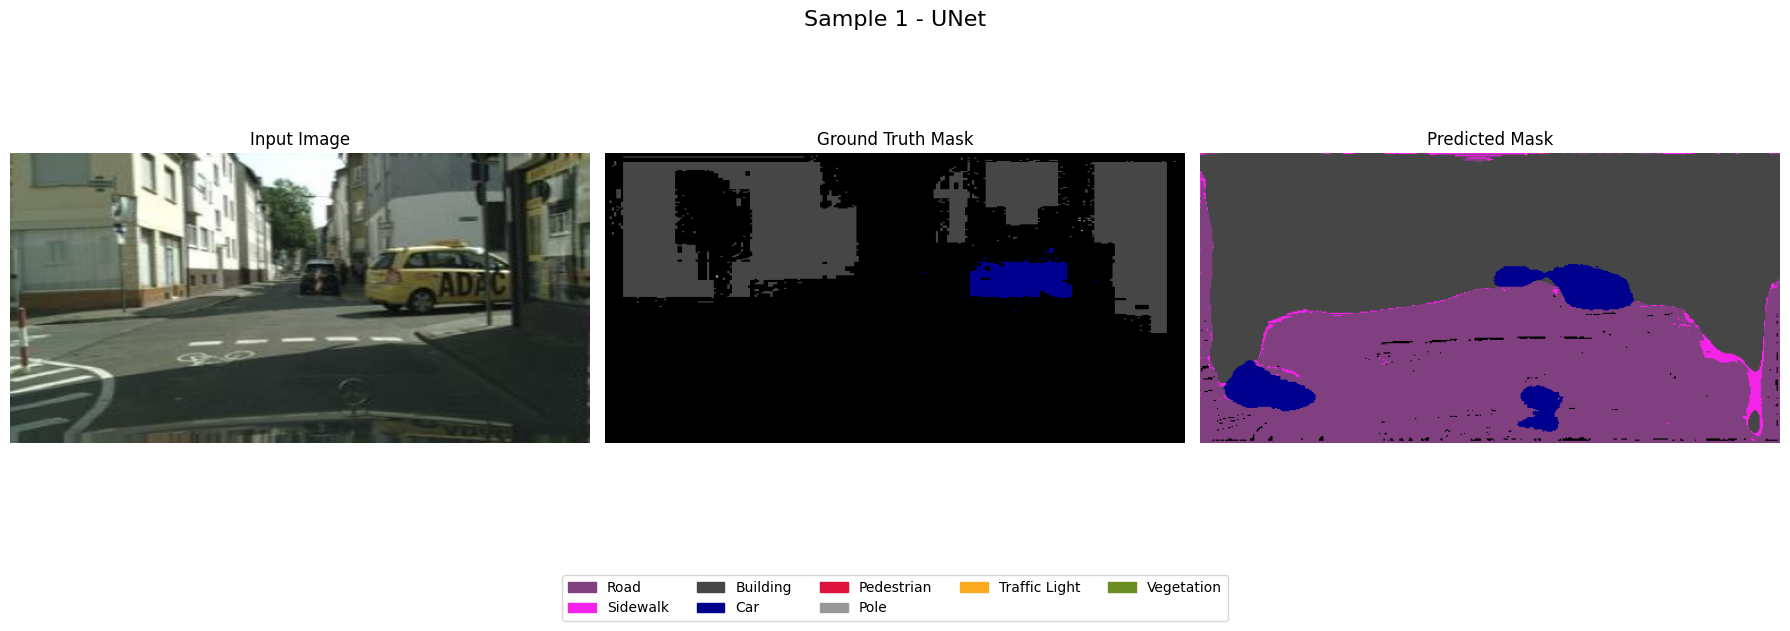

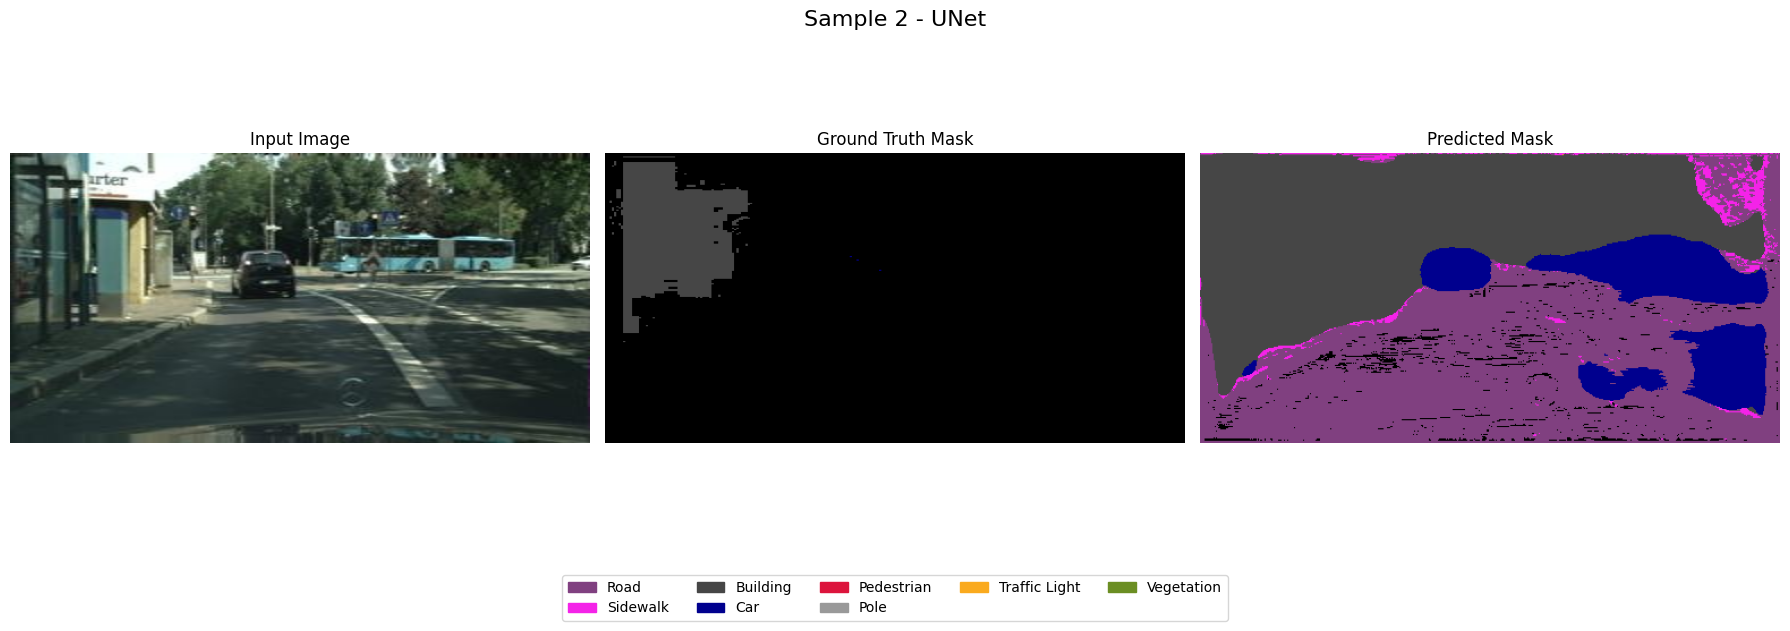


--- Visualizing FCN-VGG16 Predictions ---


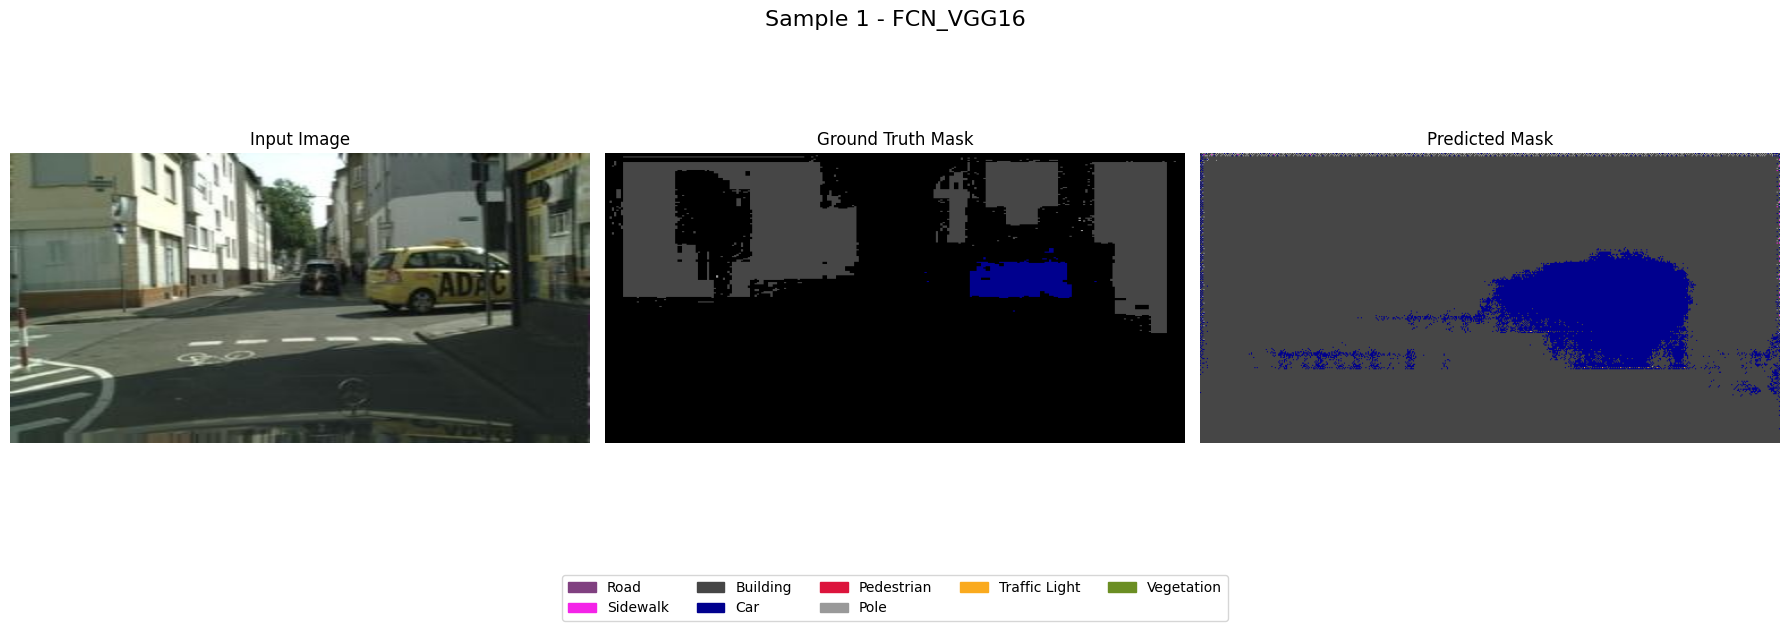

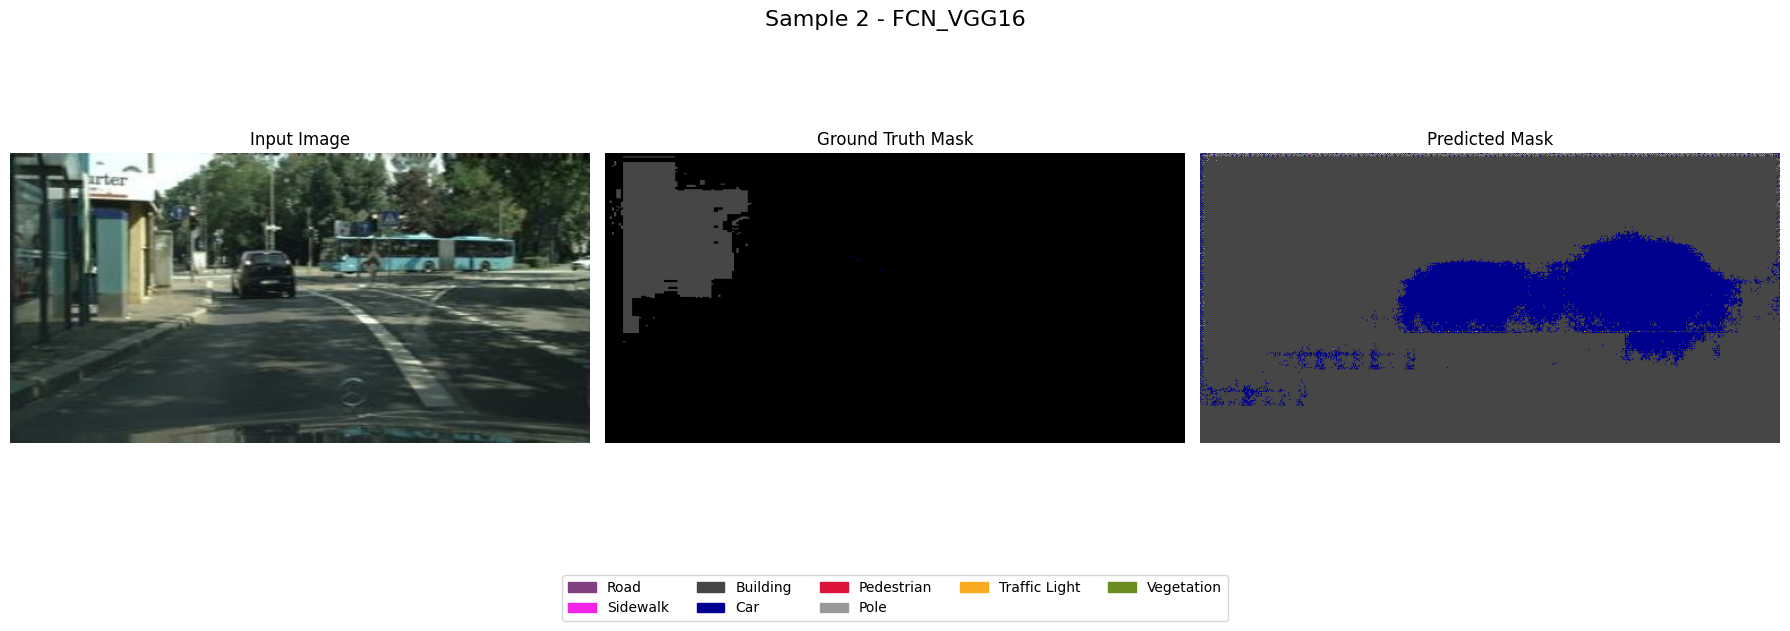

In [101]:
def tensor_to_pil_image(tensor_img): # For input images
    inv_normalize = T.Compose([
        T.Normalize(mean=[0., 0., 0.], std=[1/0.229, 1/0.224, 1/0.225]), # Denormalize std
        T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),   # Denormalize mean
        T.ToDtype(torch.uint8, scale=True) # Scale to [0, 255] and convert to uint8
    ])
    pil_img = T.ToPILImage()(inv_normalize(tensor_img.cpu().detach()))
    return pil_img

def class_ids_to_rgb_mask(mask_tensor, id_to_color_map): # For GT and Pred masks
    mask_np = mask_tensor.cpu().numpy()
    rgb_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for class_id, color in id_to_color_map.items():
        rgb_mask[mask_np == class_id] = color
    return Image.fromarray(rgb_mask)

def visualize_predictions(model, loader, device, num_samples=3, id_to_color_map=ID_TO_COLOR, class_info_map=CLASS_INFO, ignore_idx=IGNORE_INDEX):
    if len(loader.dataset) == 0:
        print("Dataset is empty. Cannot visualize predictions.")
        return

    model.eval()
    count = 0
    legend_handles = []
    for info in class_info_map.values():
        if info['id'] != ignore_idx or info['name'].lower() != "unlabeled":
             legend_handles.append(plt.Rectangle((0,0),1,1, color=np.array(info['color'])/255., label=info['name']))
        elif info['id'] == ignore_idx and info['name'].lower() == "unlabeled": # Optionally show unlabeled if it's a class
             pass # legend_handles.append(plt.Rectangle((0,0),1,1, color=np.array(info['color'])/255., label=f"{info['name']} (Ignored)"))

    with torch.no_grad():
        for images, gt_masks in loader:
            if count >= num_samples: break
            images_gpu, gt_masks_gpu = images.to(device), gt_masks.to(device) # Use gpu versions for model

            outputs = model(images_gpu)
            main_output = outputs['out'] if isinstance(outputs, dict) else outputs
            pred_masks = torch.argmax(main_output, dim=1)

            for i in range(images.size(0)): # Iterate original cpu tensors for visualization
                if count >= num_samples: break
                img_pil = tensor_to_pil_image(images[i]) # Use original non-gpu tensor
                gt_mask_pil = class_ids_to_rgb_mask(gt_masks[i], id_to_color_map) # Use original non-gpu tensor
                pred_mask_pil = class_ids_to_rgb_mask(pred_masks[i], id_to_color_map) # Use cpu version of pred_masks

                fig, axes = plt.subplots(1, 3, figsize=(18, 6))
                axes[0].imshow(img_pil); axes[0].set_title("Input Image"); axes[0].axis('off')
                axes[1].imshow(gt_mask_pil); axes[1].set_title("Ground Truth Mask"); axes[1].axis('off')
                axes[2].imshow(pred_mask_pil); axes[2].set_title("Predicted Mask"); axes[2].axis('off')

                fig.legend(handles=legend_handles, loc='lower center', ncol=min(len(legend_handles), 5), bbox_to_anchor=(0.5, -0.05))
                plt.tight_layout(rect=[0, 0.05, 1, 0.95])
                plt.suptitle(f"Sample {count+1} - {model.__class__.__name__}", fontsize=16)
                plt.show()
                count += 1
            if count >= num_samples: break

print("\n--- Visualizing U-Net Predictions ---")
if unet_history and unet_history['train_loss']: visualize_predictions(unet_model, val_loader, DEVICE, num_samples=2)

print("\n--- Visualizing FCN-VGG16 Predictions ---")
if fcn_history and fcn_history['train_loss']: visualize_predictions(fcn_model, val_loader, DEVICE, num_samples=2)

# As we can see the predicted results are incredible